In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import string
import re
import pickle
import spacy

import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC

from scipy.sparse import hstack
from scipy.stats import norm

from collections import Counter
from autocorrect import Speller

Import and Merge Data

In [3]:
review_data = pd.read_csv('Data/data_reviews.csv', delimiter=',', header=0)
review_columns = ['app_id', 'review_text', 'review_score']
review_data = review_data.filter(review_columns)

genre_data = pd.read_csv('Data/data_genres.csv', delimiter=',', header=0)
genre_columns = ['appid', 'genres', 'release_date']
genre_data = genre_data.filter(genre_columns)

data = pd.merge(review_data, genre_data, left_on='app_id', right_on='appid')
data = data.drop(columns=['appid', 'app_id'], axis=1)
data['review_text'] = data['review_text'].astype(str)
data['release_date'] = pd.to_datetime(data['release_date'])

Preprocess Data

In [138]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

nlp = spacy.load("en_core_web_sm")
punctuations = set(string.punctuation)
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
spell_checker = Speller()

# Remove non-english characters
data["review_text"] = data["review_text"].apply(lambda x: [re.sub(r'[^a-z]', '', word)
                                                           for word in x.lower().split()
                                                           if re.match(r'^[a-z]+$', word)])

preprocessed_reviews = [word for review in data['review_text'] for word in review]
print("Number of unique words 1:", len(set(preprocessed_reviews)))


# Apply spell checking
#data["review_text"] = data["review_text"].apply(lambda x: [spell_checker(word) for word in x])
#preprocessed_reviews = [word for review in data['review_text'] for word in review]
#print("Number of unique words 2:", len(set(preprocessed_reviews)))

# Stem and lemmetize
data["review_text"] = data["review_text"].apply(lambda x: [lemmatizer.lemmatize(stemmer.stem(word))
                                                           for word in x
                                                           if word not in stop_words and word not in punctuations])

preprocessed_reviews = [word for review in data['review_text'] for word in review]
print("Number of unique words 3:", len(set(preprocessed_reviews)))

# Remove words with frequency <= 100
word_counts = Counter(preprocessed_reviews)
data["review_text"] = data["review_text"].apply(lambda x: [word for word in x if word_counts[word] > 100])

preprocessed_reviews = [word for review in data['review_text'] for word in review]
print("Number of unique words 4:", len(set(preprocessed_reviews)))

# Convert back to untokenized form
data["review_text"] = data["review_text"].apply(lambda x: ' '.join(x))

print(data)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Danj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Danj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Danj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Number of unique words 1: 492792
Number of unique words 3: 360911
Number of unique words 4: 17310
                                               review_text  review_score  \
0                                                     ruin             1   
1        experi type say thing like suit someth experie...             1   
2                                                game save             1   
3        like origin like game like game run low end li...             1   
4                                                easi hard             1   
...                                                    ...           ...   
5858833  realli ove game need basic puzzl pay play get ...            -1   
5858834  use play puzzel pirat back hardli voyag everyt...            -1   
5858835  game though bit select would take hous locat w...            -1   
5858836  nice review recommend know purchas anyth puzzl...            -1   
5858837  puzzl game pay basic everyth buy someth game g...        

In [139]:
# Save preprocessed data using pickle
with open("Data/preprocessed_data.pkl", "wb") as file:
    pickle.dump(data, file)

In [2]:
with open("Data/preprocessed_data.pkl", "rb") as file:
    data = pickle.load(file)

                                               review_text  review_score  \
0                                                ruin life             1   
1        experi game type review say thing like great g...             1   
2                                         game save virgin             1   
3        like origin game like game lag like game run l...             1   
4                                   easi learn hard master             1   
...                                                    ...           ...   
5858833  realli ove game need someth basic puzzl mmo pa...            -1   
5858834  use play puzzel pirat back steam hardli voyag ...            -1   
5858835  game aright though bit annoy select puzzl woul...            -1   
5858836  nice review recommend game know purchas anyth ...            -1   
5858837  puzzl game fun pay basic anyth everyth expir b...            -1   

                                                    genres release_date  
0            

Word Counting

In [152]:
# Get the list of unique words in the dataset
words = set()
word_count_total = {}

# Count the occurrence of each word and add words to the set
for i, review in enumerate(data['review_text']):
    for word in review.split():
        word_count_total[word] = word_count_total.get(word, 0) + 1
        words.add(word)

# Create dictionaries to store word counts in positive/negative reviews, per genre, and per year
word_count_positive = {word: 0 for word in words}
word_count_negative = {word: 0 for word in words}
word_count_genre = {genre: {word: {'positive': 0, 'negative': 0} for word in words} for genre in set(data['genres'])}
word_count_year = {year: {word: {'positive': 0, 'negative': 0} for word in words} for year in set(data['release_date'].dt.year)}

# Count the occurrence of each word
for i, review in enumerate(data['review_text']):
    genres = data['genres'][i].split(';')
    year = data['release_date'][i].year
    score = data['review_score'][i]

    for word in review.split():
        if word in words:
            if score == 1:
                word_count_positive[word] += 1
                for genre in genres:
                    word_count_genre.setdefault(genre, {}).setdefault(word, {'positive': 0, 'negative': 0})['positive'] += 1
            else:
                word_count_negative[word] += 1
                for genre in genres:
                    word_count_genre.setdefault(genre, {}).setdefault(word, {'positive': 0, 'negative': 0})['negative'] += 1
            word_count_year[year][word]['positive' if score == 1 else 'negative'] += 1

In [154]:
#Calculate the positive PMI for each word
pmi_positive = {}
total_reviews = len(data)
for word in words:
    p_word = word_count_total[word] / sum(word_count_total.values())
    p_positive_given_word = word_count_positive[word] / word_count_total[word]
    p_positive = sum(data['review_score'] == 1) / total_reviews

    pmi_positive[word] = np.log2(p_positive_given_word / (p_positive * p_word))


#Sort words based on PMI in descending order
sorted_positive_pmi = sorted(pmi_positive.items(), key=lambda x: x[1], reverse=True)

#Calculate the negative PMI for each word
pmi_negative = {}
total_reviews = len(data)
for word in words:
    p_word = word_count_total[word] / sum(word_count_total.values())
    p_negative_given_word = word_count_negative[word] / word_count_total[word]
    p_negative = sum(data['review_score'] == -1) / total_reviews

    pmi_negative[word] = np.log2(p_negative_given_word / (p_negative * p_word))

#Sort words based on PMI in descending order
sorted_negative_pmi = sorted(pmi_negative.items(), key=lambda x: x[1], reverse=True)

C:\Users\Danj\AppData\Local\Temp\ipykernel_12628\3739037108.py:9: RuntimeWarning: divide by zero encountered in log2
  pmi_positive[word] = np.log2(p_positive_given_word / (p_positive * p_word))
C:\Users\Danj\AppData\Local\Temp\ipykernel_12628\3739037108.py:23: RuntimeWarning: divide by zero encountered in log2
  pmi_negative[word] = np.log2(p_negative_given_word / (p_negative * p_word))


In [ ]:
def getDistribution(values):
    mean = np.mean(values)
    std = np.std(values)
    print(f"Mean PMI: {mean}")
    print(f"Standard Deviation PMI: {std}")

    plt.hist(values, bins='auto', alpha=0.7)
    plt.axvline(mean, color='r', linestyle='dashed', linewidth=1.5, label='Mean')
    plt.xlabel('PMI Values')
    plt.ylabel('Frequency')
    plt.title('Distribution of PMI Values')
    plt.legend()
    plt.show()

---------------------Positive PMI------------------------
Word: true | PMI: 11.379732527173115 | Positive Count: 44826 | Total Count: 51040 | p-value: 2.6380650687933135e-30
Word: fairli | PMI: 11.321718665304848 | Positive Count: 41506 | Total Count: 50111 | p-value: 5.122178096927915e-30
Word: star | PMI: 11.320786555658112 | Positive Count: 44061 | Total Count: 51647 | p-value: 5.176936656772797e-30
Word: addit | PMI: 11.305132796413147 | Positive Count: 42462 | Total Count: 50977 | p-value: 6.188339077718946e-30
Word: reward | PMI: 11.295131329795947 | Positive Count: 41939 | Total Count: 50838 | p-value: 6.934828660891802e-30
Word: provid | PMI: 11.294928532577146 | Positive Count: 43668 | Total Count: 51879 | p-value: 6.950854705373791e-30
Word: stealth | PMI: 11.288714240753016 | Positive Count: 43988 | Total Count: 52181 | p-value: 7.460163478915688e-30
Word: mix | PMI: 11.283149711999377 | Positive Count: 48243 | Total Count: 54752 | p-value: 7.947550886655201e-30
Word: head |

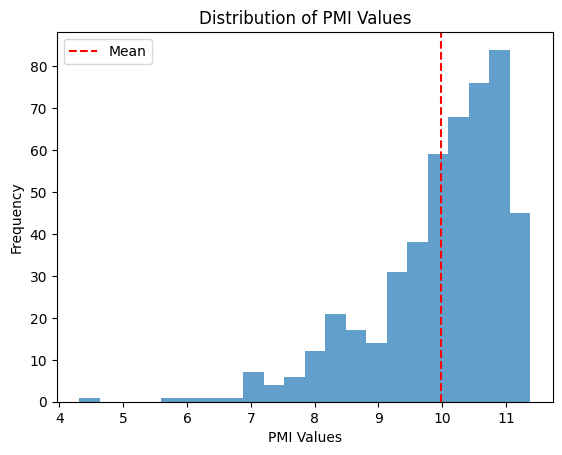

---------------------Negative PMI------------------------
Word: worst | PMI: 13.19161571012571 | Negative Count: 35008 | Total Count: 52494 | p-value: 4.903037981909723e-40
Word: terribl | PMI: 12.950291330808183 | Negative Count: 31516 | Total Count: 54152 | p-value: 1.1703204994881528e-38
Word: wast | PMI: 12.47950930480472 | Negative Count: 52541 | Total Count: 82311 | p-value: 4.8290001754045784e-36
Word: window | PMI: 12.385853876267001 | Negative Count: 21642 | Total Count: 54570 | p-value: 1.5587450614895722e-35
Word: suck | PMI: 12.37678756792408 | Negative Count: 20060 | Total Count: 52703 | p-value: 1.7451786385992703e-35
Word: patch | PMI: 12.340474218965824 | Negative Count: 20978 | Total Count: 54578 | p-value: 2.7415987222565566e-35
Word: unless | PMI: 12.312395441047808 | Negative Count: 32311 | Total Count: 68397 | p-value: 3.8841390145655465e-35
Word: grind | PMI: 12.308257534067469 | Negative Count: 18186 | Total Count: 51387 | p-value: 4.088475506691725e-35
Word: gue

In [ ]:
print("--------------------------Positive PMI-----------------------------")
filtered_positive_pmi = [(word, pmi_value) for word, pmi_value in sorted_positive_pmi if word_count_total[word] > 50000]

for word, pmi_value in filtered_positive_pmi:
    count_positive = word_count_positive[word]
    count_total = word_count_total[word]
    print(f"Word: {word} | PMI: {pmi_value} | Positive Count: {count_positive} | Total Count: {count_total}")

pmi_values = [pmi_value for _, pmi_value in filtered_positive_pmi]
getDistribution(pmi_values)

print("--------------------------Negative PMI-----------------------------")
filtered_negative_pmi = [(word, pmi_value) for word, pmi_value in sorted_negative_pmi if word_count_total[word] > 50000]

for word, pmi_value in filtered_negative_pmi:
    count_negative = word_count_negative[word]
    count_total = word_count_total[word]
    print(f"Word: {word} | PMI: {pmi_value} | Negative Count: {count_negative} | Total Count: {count_total}")

pmi_values = [pmi_value for _, pmi_value in filtered_negative_pmi]
getDistribution(pmi_values)

# Compute PMI ratios for Positive PMI/Negative PMI and Negative PMI/Positive PMI

positive_negative_pmi_ratio = {}
negative_positive_pmi_ratio = {}

positive_words = [word for word, _ in filtered_positive_pmi]
negative_words = [word for word, _ in filtered_negative_pmi]
common_words = set(positive_words) & set(negative_words)

# Positive/Negative PMI ratio
for word in common_words:
    pmi_positive_value = filtered_positive_pmi[positive_words.index(word)][1]
    pmi_negative_value = filtered_negative_pmi[negative_words.index(word)][1]
    positive_negative_pmi_ratio[word] = pmi_positive_value / pmi_negative_value

# Negative/Positive PMI ratio
for word in common_words:
    pmi_negative_value = filtered_negative_pmi[negative_words.index(word)][1]
    pmi_positive_value = filtered_positive_pmi[positive_words.index(word)][1]
    negative_positive_pmi_ratio[word] = pmi_negative_value / pmi_positive_value

# Print PMI ratios
sorted_positive_negative_pmi_ratio = sorted(positive_negative_pmi_ratio.items(), key=lambda x: x[1], reverse=True)
sorted_negative_positive_pmi_ratio = sorted(negative_positive_pmi_ratio.items(), key=lambda x: x[1], reverse=True)

print("---------------------------Positive/Negative PMI Ratio----------------------------")
for word, pmi_ratio in sorted_positive_negative_pmi_ratio:
    count_positive = word_count_positive[word]
    count_negative = word_count_negative[word]
    print(f"Word: {word} | Positive/Negative PMI Ratio: {pmi_ratio} | Positive Count: {count_positive} | Negative Count: {count_negative}")

pmi_values = [pmi_value for _, pmi_value in sorted_positive_negative_pmi_ratio]
getDistribution(pmi_values)

print("--------------------------Negative/Positive PMI Ratio-----------------------------")
for word, pmi_ratio in sorted_negative_positive_pmi_ratio:
    count_positive = word_count_positive[word]
    count_negative = word_count_negative[word]
    print(f"Word: {word} | Negative/Positive PMI Ratio: {pmi_ratio} | Positive Count: {count_positive} | Negative Count: {count_negative}")

pmi_values = [pmi_value for _, pmi_value in sorted_negative_positive_pmi_ratio]
getDistribution(pmi_values)

In [161]:
# Create a dictionary to store the PMI values per genre
pmi_per_genre = {genre: {} for genre in set(data['genres'])}

# Calculate the PMI for each genre, positive/negative reviews, and word
for genre in set(data['genres']):
    genre_data = data[data['genres'].str.contains(genre)]
    genre_word_count_total = {}

    for i, review in enumerate(genre_data['review_text']):
        for word in review.split():
            genre_word_count_total[word] = genre_word_count_total.get(word, 0) + 1

    for word in words:
        p_word = word_count_total[word] / sum(word_count_total.values())

        for score in [1, 0]:
            genre_score_data = genre_data[genre_data['review_score'] == score]
            genre_score_word_count = {}

            for i, review in enumerate(genre_score_data['review_text']):
                for w in review.split():
                    genre_score_word_count[w] = genre_score_word_count.get(w, 0) + 1

            p_genre_score = genre_score_data.shape[0] / data.shape[0]
            p_word_given_genre_score = genre_score_word_count.get(word, 0)

            if p_word_given_genre_score > 0 and sum(genre_score_word_count.values()) > 0:
                p_word_given_genre_score /= sum(genre_score_word_count.values())
                pmi_value = np.log2(p_word_given_genre_score / (p_word * p_genre_score))
                pmi_per_genre[genre].setdefault(score, {})[word] = pmi_value

# Print the PMI values for each genre, positive/negative reviews, and word
for genre in pmi_per_genre:
    print(f"Genre: {genre}")
    for score in [1, 0]:
        print(f"Positive Score: {score}")
        for word, pmi_value in pmi_per_genre[genre].get(score, {}).items():
            count_positive = word_count_genre[genre][word]['positive']
            count_negative = word_count_genre[genre][word]['negative']
            print(f"Word: {word} | PMI: {pmi_value} | Positive Count: {count_positive} | Negative Count: {count_negative}")

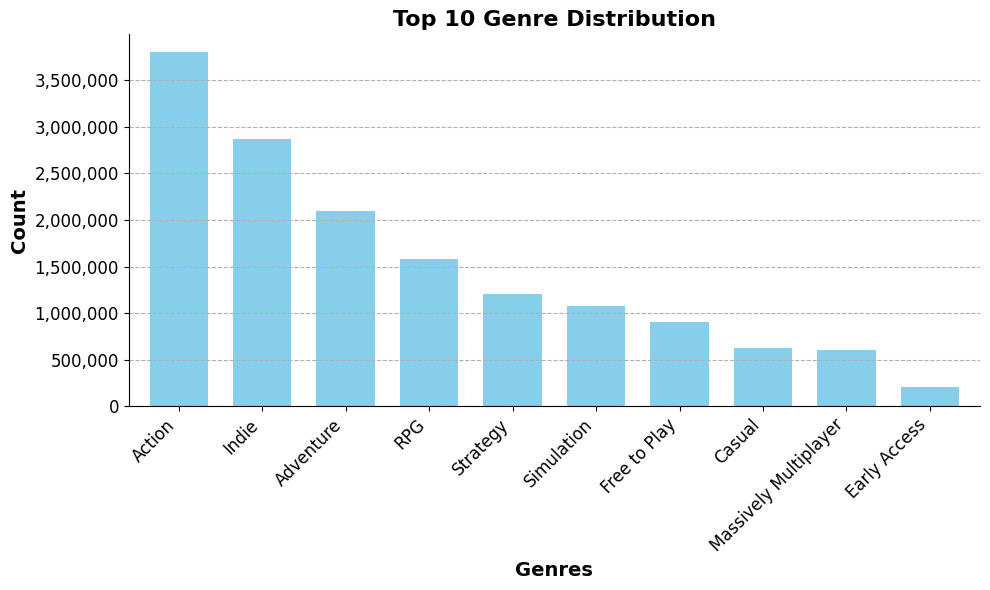

In [ ]:
from matplotlib.ticker import FuncFormatter

# Count the occurrences of each genre
genre_counts = data['genres'].str.split(';').explode().value_counts().head(10)

# Plot the bar graph
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', width=0.7, color='skyblue', alpha=1.0)

# Adjust the appearance
plt.title('Top 10 Genre Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Genres', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Format y-axis labels
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

# Remove the top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add a grid
plt.grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()

Split

In [6]:
# Convert 'review_text' column to string type
data['review_text'] = data['review_text'].astype(str)

# Create a CountVectorizer object for review text
vectorizer = CountVectorizer()
bow_matrix = vectorizer.fit_transform(data['review_text'])

# One-hot encode the 'genres' column
encoder = OneHotEncoder()
genre_matrix = encoder.fit_transform(data['genres'].str.get_dummies(';'))

# Concatenate the review text matrix and genre matrix
combined_matrix = hstack((bow_matrix, genre_matrix))

# Split the data into train, dev, and test sets (70/15/15)
train_data, dev_data, train_labels, dev_labels = train_test_split(combined_matrix, data['review_score'], test_size=0.3, random_state=42)
dev_data, test_data, dev_labels, test_labels = train_test_split(dev_data, dev_labels, test_size=0.5, random_state=42)

Metrics Function

In [7]:
# Define a function to count word frequencies
def metrics(labels, predictions):
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)


    # Calculate the confusion matrix
    cm = confusion_matrix(labels, predictions)

    # Calculate the percentages for each cell
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Display the confusion matrix with percentages
    plt.figure(figsize=(8, 6))
    plt.imshow(cm_percent, interpolation="nearest", cmap="Blues")
    plt.colorbar()
    tick_marks = [0, 1]
    plt.xticks(tick_marks, ["Negative", "Positive"])
    plt.yticks(tick_marks, ["Negative", "Positive"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix (Percentages)")

    # Add percentage values to each cell
    thresh = cm_percent.max() / 2
    for i in range(cm_percent.shape[0]):
        for j in range(cm_percent.shape[1]):
            plt.text(j, i, "{:.1f}%".format(cm_percent[i, j]),
                    ha="center", va="center",
                    color="white" if cm_percent[i, j] > thresh else "black")

    plt.show()
    return

Baseline

In [22]:
# Calculate the proportion of positive reviews
proportion_positive = len(data[data['review_score'] == 1]) / len(data)

# Calculate the baseline accuracy
baseline_accuracy = max(proportion_positive, 1 - proportion_positive)

print("Proportion of positive reviews: ", proportion_positive)
print("Baseline accuracy: ", baseline_accuracy)

Proportion of positive reviews:  0.8262517243180303
Baseline accuracy:  0.8262517243180303


Logistic Regression

C:\Users\Danj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Danj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable

Best weight: 0.56
Best F1-score: 0.9293635818585192


C:\Users\Danj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8778722978154948
Precision: 0.8898254033467509
Recall: 0.9725787944697516
F1-Score: 0.9293635818585192


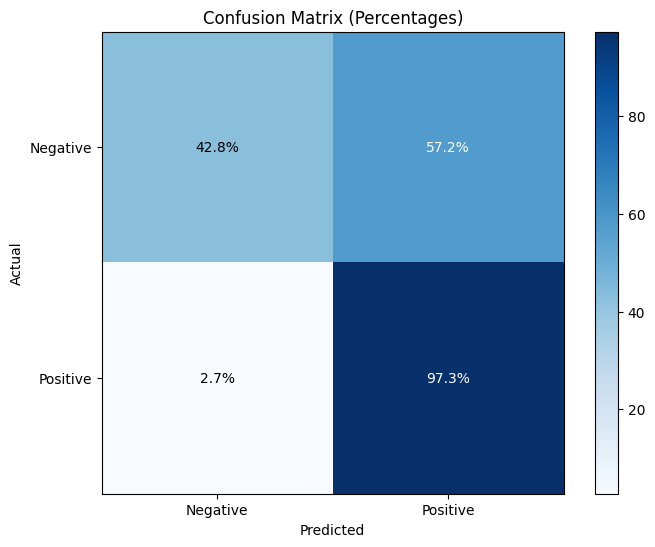

C:\Users\Danj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8515610598685064
Precision: 0.9273971875219792
Recall: 0.889980453764682
F1-Score: 0.9083036469916747


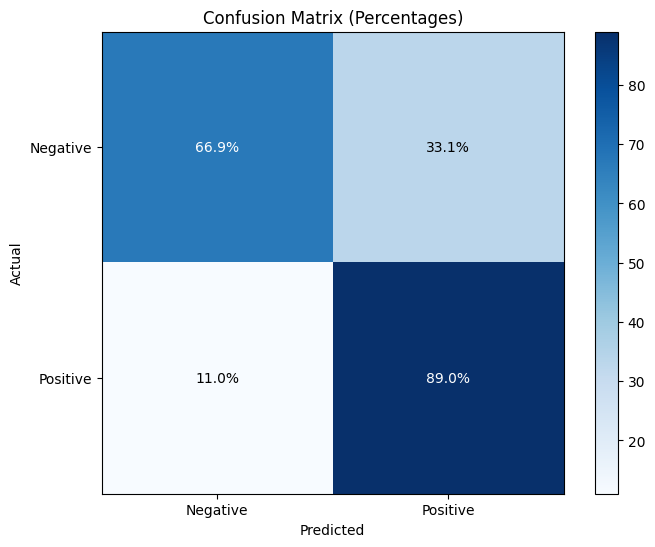

In [10]:
best_f1_score = 0.0
best_weight = None

weight = 0.5
increment = 0.02

while weight <= 0.9:
    lr = LogisticRegression(random_state=42, class_weight={-1: weight, 1: 1-weight})
    lr.fit(train_data, train_labels)
    dev_predictions = lr.predict(dev_data)
    f1 = f1_score(dev_labels, dev_predictions)
    
    if f1 > best_f1_score:
        best_f1_score = f1
        best_weight = weight
    
    weight += increment

print("Best weight:", best_weight)
print("Best F1-score:", best_f1_score)

# Run the model with the best weight and evaluate the metrics
lr_best = LogisticRegression(random_state=42, class_weight={-1: best_weight, 1: 1-best_weight})
lr_best.fit(train_data, train_labels)
dev_predictions = lr_best.predict(dev_data)

metrics(dev_labels, dev_predictions)

# Logistic Regression Classifier
logistic_regression = LogisticRegression(random_state=42, class_weight={-1: 0.75, 1: 0.25})
logistic_regression.fit(train_data, train_labels)


dev_predictions = lr_best.predict(dev_data)

metrics(dev_labels, dev_predictions)

C:\Users\Danj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Danj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Danj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentat

Best Solver: lbfgs
Best F1 Score: 0.8984109552905555
Accuracy: 0.809699530965174
Precision: 0.9120974760661444
Recall: 0.8517144624234302
F1-Score: 0.880872381633486


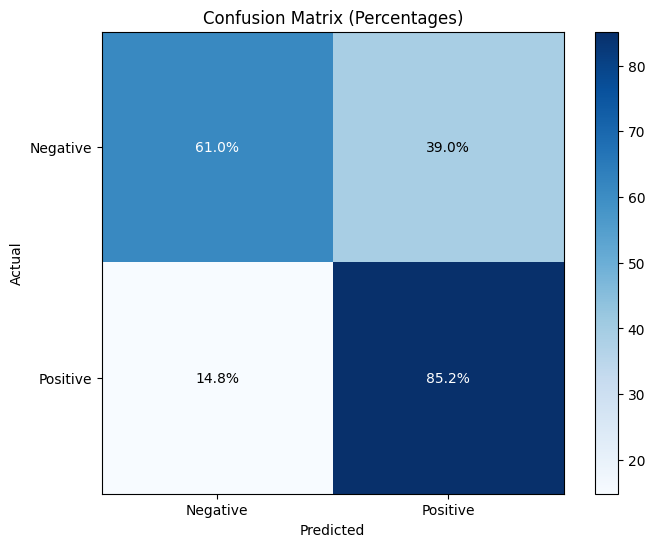

In [8]:
# Define the list of solvers to iterate through
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

best_f1_score = 0.0
best_solver = None

# Iterate through each solver option
for solver in solvers:
    # Logistic Regression Model
    logistic_regression = LogisticRegression(random_state=42, class_weight={-1: 0.80, 1: 0.20})
    logistic_regression.fit(train_data, train_labels)

    # Make predictions on the development set
    dev_predictions = lr.predict(dev_data)

    # Calculate the F1 score
    f1 = f1_score(dev_labels, dev_predictions)

    # Check if this solver produces a better F1 score
    if f1 > best_f1_score:
        best_f1_score = f1
        best_solver = solver

# Print the best solver and its corresponding F1 score
print("Best Solver:", best_solver)
print("Best F1 Score:", best_f1_score)

metrics(dev_labels, dev_predictions)

Metrics for max_depth=20:
Accuracy: 0.8003245238534136
Precision: 0.8917934826704169
Recall: 0.862994527329604
F1-Score: 0.8771576859050555


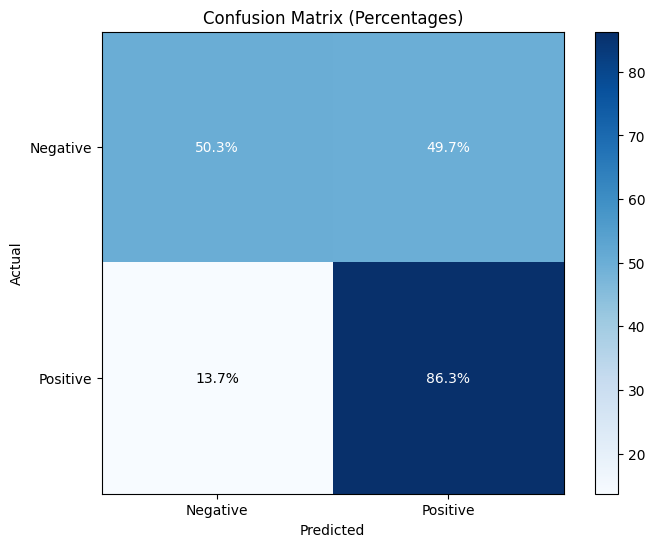


Metrics for max_depth=30:
Accuracy: 0.8013395143065862
Precision: 0.9039252429559976
Recall: 0.8498369769591347
F1-Score: 0.8760470343670084


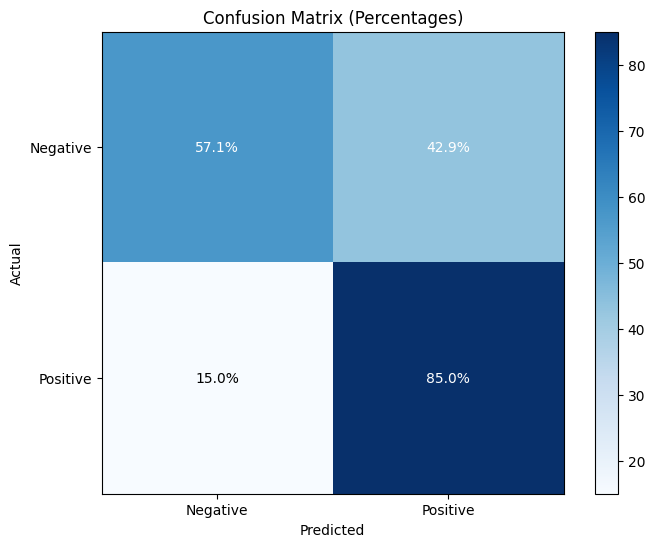


Metrics for max_depth=40:
Accuracy: 0.8042638702086647
Precision: 0.9091311945428789
Recall: 0.8477886857739496
F1-Score: 0.8773890594016357


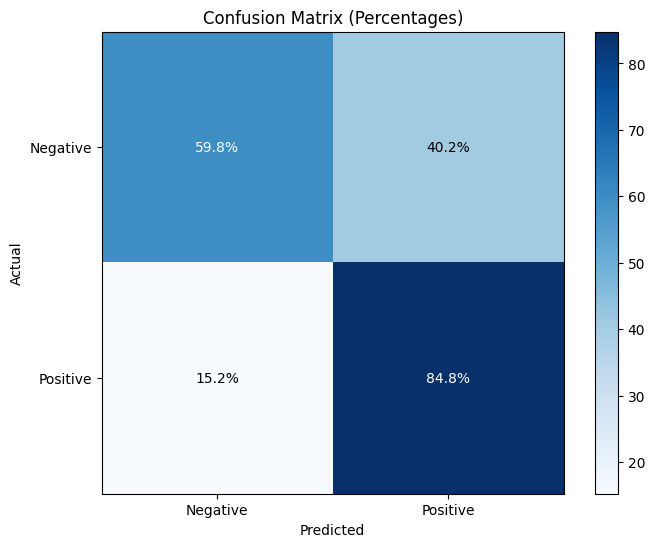

In [5]:
from sklearn.tree import DecisionTreeClassifier

# Define the max_depth values to try
max_depths = [20, 30, 40, 50]

for max_depth in max_depths:
    
    # Decision Tree Classifier
    decision_tree = DecisionTreeClassifier(random_state=42, max_depth=30, class_weight={-1: 0.80, 1: 0.20})
    decision_tree.fit(train_data, train_labels)

    # Make predictions on the dev set
    dev_predictions = decision_tree.predict(dev_data)

    # Calculate and print the metrics for the current max_depth
    print(f"Metrics for max_depth={max_depth}:")
    metrics(dev_labels, dev_predictions)
    print()